# Linear dynamics naive


In this notebook find analytic solution to

$Y_{t} = A \cdot Y_{t-1} $

where Y is the neural activity at time t. 

This leads to poor prediction

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 
from scipy.ndimage import gaussian_filter1d
import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)

#sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

from mecll.rsync import Rsync_aligner
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.load import load_data
from mecll.SVD_analysis import get_mean_activity_matrix
from mecll.utils import align_activity

In [3]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [4]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-07-29_39955_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

474 475


In [5]:
#root_path = '/Users/yves/Downloads/example_files2_wOF/'
#out = load_data(root_path,align_to='task')
#spkT,spkC,single_units,events,lines,aligner = out

In [6]:
df = build_poke_df(lines,events)

In [7]:
df['previous_port'][1:] = df['port'][:-1]
df['previous_state'][1:] = df['state'][:-1]

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
a,b = np.histogram(spkT)

In [9]:
spkT_ms = aligner.A_to_B(spkT)

In [10]:
np.sum(np.isfinite(spkT_ms))/len(spkT)

0.3554985558117623

In [11]:
#poke_dict_t1 ={}
#poke_dict_t2 = {}

dicts = [{} for _ in range(4)]

for port_nr in np.unique(df['state'].values):
    
    kk = 0
    for task_nr in range(2):
        for direction in np.unique(df['direction'].values):
            task_nr = str(task_nr)
            indices = np.where((df['state']==port_nr) &
                               (df['correct']==True) & 
                               (df['direction']==direction) &
                               (df['port_repeat']==False) & 
                               (df['task_nr']==task_nr))[0]
            indices = indices[indices>0]
            v = df.loc[indices]['time'].values.astype('float')
            prev_v = df.loc[indices-1]['time'].values
            #print(direction,df.loc[indices]['state'].values - df.loc[indices-1]['state'].values)

            
            dicts[kk][str(port_nr)] = v
            dicts[kk]['task_nr'] = str(task_nr)
            dicts[kk]['direction'] = str(direction)
            dicts[kk]['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            dicts[kk]['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            kk += 1


In [12]:
#df.loc[:50]

In [13]:
window0 = 3000; window1 = 3000
n_neurons = len(single_units)

n_tasks = 2; n_direction = 2; n_states = 9
all_big_array = np.zeros([n_neurons,n_tasks,n_direction,n_states])


for unit_ix,unit in enumerate(single_units):
        
    spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell

    for dict_ix in range(len(dicts)):

        for state_nr in range(9):
            direction = (int(dicts[dict_ix]['direction'])+1)//2
            task_nr = int(dicts[dict_ix]['task_nr'])
            trial_events = np.array(dicts[dict_ix][str(state_nr)])


            aligned_T = aligner.B_to_A(trial_events) #align pokes into spike times

            #get the spikes that are in bounds for position encoding
            pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]

            used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
            half_npks = int(len(used_pks)/2)

            #print(key,half_npks)
            n_pokes = 0
            mean_rate = 0
            for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                spike_locs = np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1))
                mean_rate += 5*np.sum(spike_locs)
                n_pokes += 1
            all_big_array[unit_ix,task_nr,direction,state_nr] = mean_rate/(n_pokes+1e-12)

In [14]:
#AB2 = all_big_array #- np.mean(all_big_array,axis=(1,2,3))[:,None,None,None]
#AB2_resh = AB2.reshape(n_neurons,-1)

In [15]:
AB1 = []
for task in range(2):
    for direction in range(2):
        AB1.append(all_big_array[:,task,direction,:])
AB1 = np.hstack(AB1)

In [16]:
AB2 = AB1 - np.mean(AB1,axis=1)[:,None]

In [17]:
U,S,Vt = np.linalg.svd(AB2)
V = Vt.T

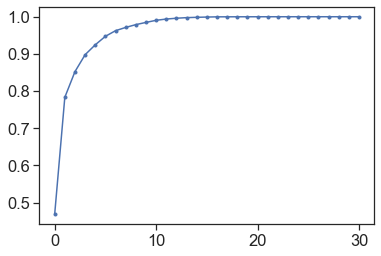

In [18]:
plt.plot(np.cumsum(S**2)/np.sum(S**2),marker='.')

In [19]:
#this should be the first 5 PCs, basically
nDIM = 3
trial_activity = Vt[:nDIM]  #need to check that this is the correct dimension


In [20]:
Y = trial_activity

In [21]:
#Y = trial_activity.reshape(nDIM,2,2,9)

In [22]:
#this is the estimate of the transition matrix, I think
Test = np.linalg.pinv(Y[:,:-1].T).dot(Y[:,1:].T)

In [23]:
Y.shape

(3, 36)

In [24]:
#T_est = 
test_i = []
for i in range(7):
    test_i.append(np.dot(Y[:,i+1].reshape(-1,1),np.linalg.pinv(Y[:,i].reshape(1,-1)).T))

In [25]:
Test_all = np.sum(test_i,axis=0)

In [26]:
Test_all

array([[ 1.96740785, -1.18434508,  0.58149716],
       [-2.04036069,  0.92092894, -1.15174222],
       [ 0.99756203,  0.64712679,  0.60356106]])

In [27]:
T_est = np.dot(Y[:,1:],
               np.linalg.pinv(Y[:,:-1])
              )

In [28]:
T_est

array([[ 0.46189478,  0.03801758,  0.08089351],
       [-0.0891226 , -0.08508265, -0.09455609],
       [-0.15373565, -0.1494427 , -0.28095185]])

In [29]:
all_pred = []
for i in range(8):
    all_pred.append(np.dot(Test,Y[:,i]))
    print(all_pred[-1])

[-0.01228944 -0.02215959 -0.02147464]
[-0.025934   -0.03623293 -0.06663221]
[ 0.03544126  0.00015594 -0.00289929]
[0.09271346 0.03768684 0.05763379]
[0.07569299 0.01178036 0.02140145]
[ 0.04843171 -0.00650094 -0.01908632]
[-0.0272331  -0.0412696  -0.07127444]
[-0.00818762 -0.00202558 -0.01141856]


In [30]:
all_real = []
for i in range(1,9):
    all_real.append(Y[:,i])
    print(all_real[-1])

[0.02689272 0.01884204 0.23856768]
[ 0.08321913 -0.06080266  0.05474406]
[ 0.12676025 -0.22036299 -0.09447541]
[ 0.15024534 -0.03304328 -0.02179424]
[ 0.12990531 -0.12367708  0.14696198]
[0.03634872 0.09128362 0.23343284]
[-0.01486839 -0.11422792  0.07480552]
[-0.22235435 -0.04826646 -0.07695407]


In [31]:
all_real = np.array(all_real)
all_pred = np.array(all_pred)

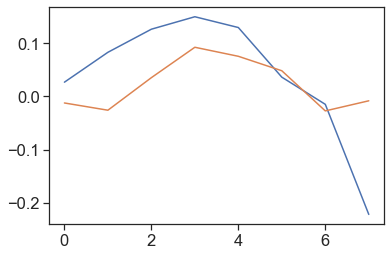

In [32]:
ix = 0
plt.plot(all_real[:,ix])
plt.plot(all_pred[:,ix])

In [33]:

a1 = np.sum(np.dot(U.T,AB2[:,1:9]).dot(all_real).diagonal()**2)

In [36]:

a2 = np.sum(np.dot(U.T,AB2[:,1:9]).dot(all_pred).diagonal()**2)

In [37]:
U2,S2,Vt2 = np.linalg.svd(AB2[:,1:9])
#V = V.T

In [38]:
S2

array([24.48594366, 16.40401759, 13.45802591,  8.00511956,  6.60893935,
        5.11345432,  3.90700222,  1.36319084])

In [39]:

a1 = np.sum(np.dot(U.T,AB2[:,19:27]).dot(all_real).diagonal()**2)

In [40]:
AB2.shape

(31, 36)

In [41]:

a2 = np.sum(np.dot(U.T,AB2[:,19:27]).dot(all_pred).diagonal()**2)